# 04b Multiple Linear regression model trained on affluent IMD regions 

> Plus: the model trained on areas with highest GP density

In [1]:
#|default_exp core.04_regression_model

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/03a_explore_datasets.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
import itertools

import scipy.stats as st

### Load the Autonomy style bits 

In [6]:
# Define the font path and style path
FONT_PATH = const.raw_data_path + '/JosefinSans-Regular.ttf'
STYLEPATH = const.raw_data_path + '/autonomy_white.mplstyle'

# Add the font to the font manager
fm.fontManager.addfont(FONT_PATH)

# Set the font family for matplotlib to use
plt.rcParams['font.family'] = 'Josefin Sans'
plt.style.use(STYLEPATH)

# Inform the user that the font was set
print("Josefin Sans font set for Matplotlib.")
print("mplstyle activated.")

Josefin Sans font set for Matplotlib.
mplstyle activated.


---

In [7]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [8]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.054537,41.277676,29.459719,51.924546,16.393357,5.298762,2.534370,186.084815,0.105584
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.520773,57.864140,16.212434,51.872532,8.334167,2.933158,1.034842,437.450820,0.224167
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.757572,45.298420,19.513040,51.475795,11.160066,3.982729,1.633168,124.734713,0.107840
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.864371,46.247977,20.734161,51.097420,11.826167,4.774197,1.863024,442.084950,0.311082
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.658556,39.900936,24.100070,51.143136,13.049211,5.147664,1.839612,78.032656,0.093811


These are the covariates I'm interested in - each is calculated as a percentage of the total population of the region. 
* Age (% people over 65) `over_65_pc`
* Gender (% people female) `female_pc`
* Educational attainment (% people with A-level or higher education) `ALevel_plus_pc`
* Ethnicity (% people who are white British) `white_pc`

Other covariates available include:
* Comorbidities (% people with various dementia comorbidities)
    - Hypertension `HYP_afflicted_pc`
    - Diabetes `DM_afflicted_pc`
    - Stroke `STIA_afflicted_pc`
* Density of GPs (total number of GPs/ pop) `GP_LAD_pc`

However we're going to leave them out of the IMD model as they seem to confound/supress. 

In [9]:
# Potential covariates 
covar_opt = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc']

How do we understand these residuals? Might be a good idea to look at the areas which we would expect to have high rates of diagnosis - for example if we look at top 50 areas accoridng to the IMD (or ADI). 

In [10]:
df_IMD = pd.read_excel(const.data_path+'/IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx', sheet_name='IMD')

In [11]:
# the 50 least deprived LADs according to the IMD
least_50_IMD = list(df_IMD[df_IMD['IMD - Rank of average rank ']>317-55]['Local Authority District name (2019)'])

# check the overlap between regions in IMD and ADI 
df_dem_topIMD = df_dem_plus[df_dem_plus['area_name'].isin(least_50_IMD)].copy()

list_45 = list(df_dem_topIMD['area_name'])
list(set(least_50_IMD).difference(list_45))

['Aylesbury Vale',
 'South Northamptonshire',
 'Wycombe',
 'South Bucks',
 'Chiltern']

Note - this discrepancy is because in 2020, the former District Council areas of Aylesbury Vale, Chiltern, South Bucks and Wycombe and Buckinghamshire County Council came together to form a single Unitary Authority, Buckinghamshire Council.

In [12]:
# check size of training set 
print(f'Size of subset of affluent (IMD) areas: {len(df_dem_topIMD)}')

Size of subset of affluent (IMD) areas: 50


## Regression trained on the IMD subset 
What happens if I include all possible covariates?

In [13]:
print(covar_opt)

['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc']


In [14]:
# Linear regression using sklearn 

x_IMD_train = df_dem_topIMD[covar_opt].values.reshape(-1,len(covar_opt))
y_IMD_train = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_IMD_train, y_IMD_train)
y_pred_all = regr.predict(x_test_all)

In [15]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:-1.7811754201707677
-------- 
 coefficients of independent variables 
 
over_65_pc:0.03558690497636593 

female_pc:0.04154508643489294 

ALevel_plus_pc:-0.006226343468360972 

white_pc:-0.0014626597590438463 



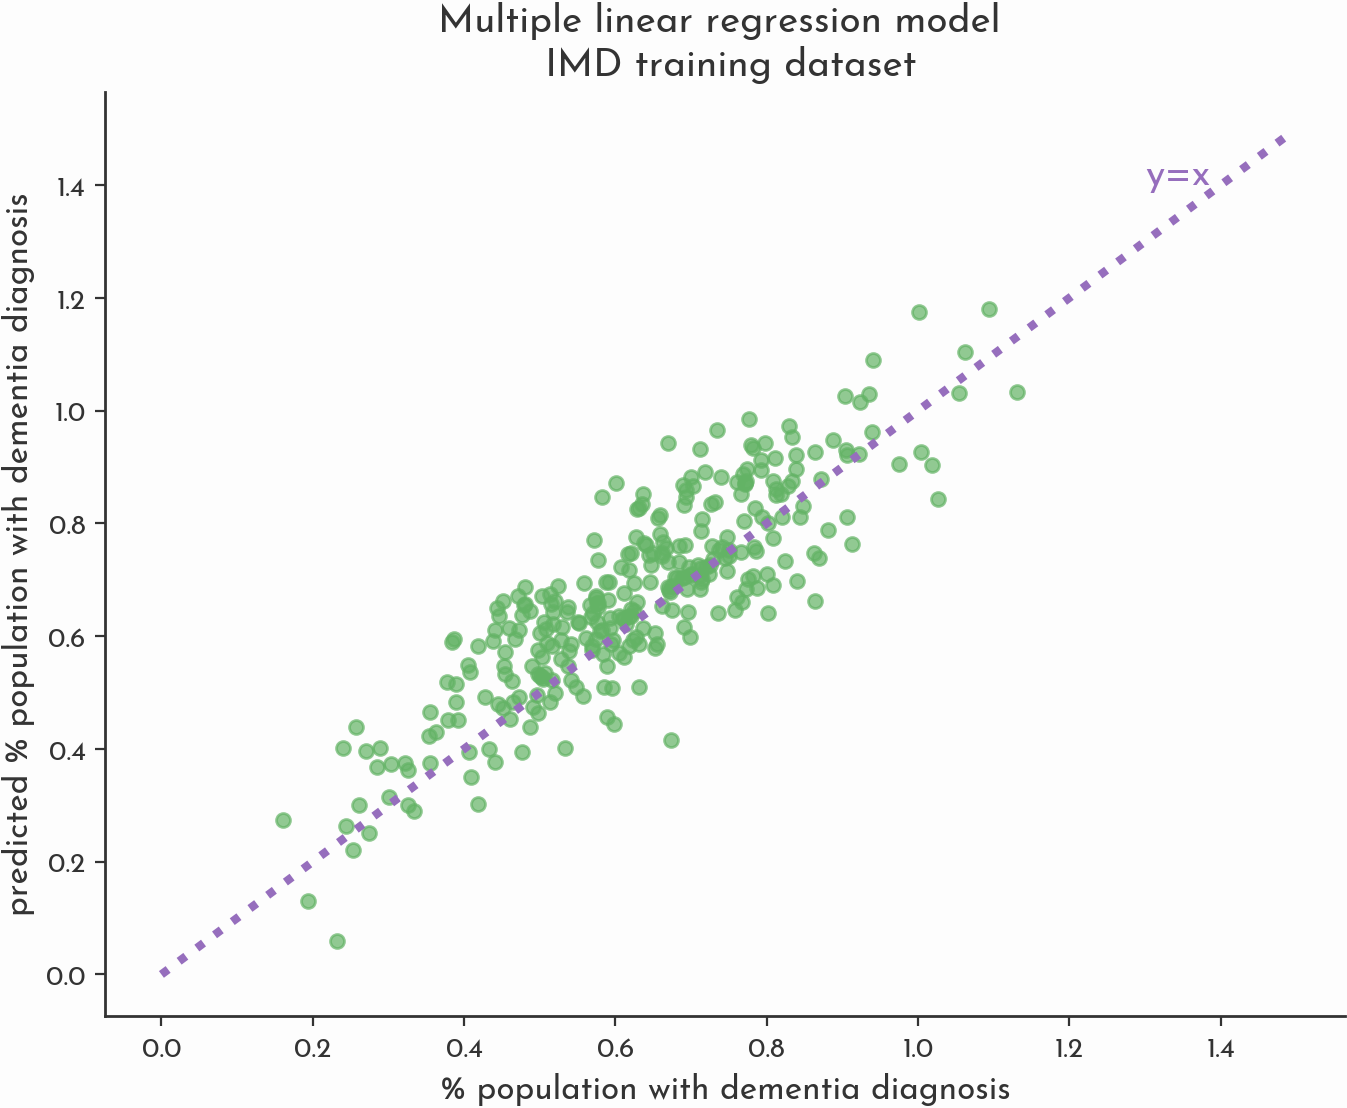

In [16]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='xkcd:deep lilac')
plt.scatter(y_test_all, y_pred_all, color='xkcd:boring green', alpha=0.7)
plt.xlabel('% population with dementia diagnosis', fontsize=12)
plt.ylabel('predicted % population with dementia diagnosis', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Multiple linear regression model \n IMD training dataset', fontsize=14)
plt.text(1.3, 1.4, r'y=x', fontsize=14, color='xkcd:deep lilac')
plt.savefig(const.figs_path+'/IMD_linear_reg_scatter_plt.png')
plt.show()

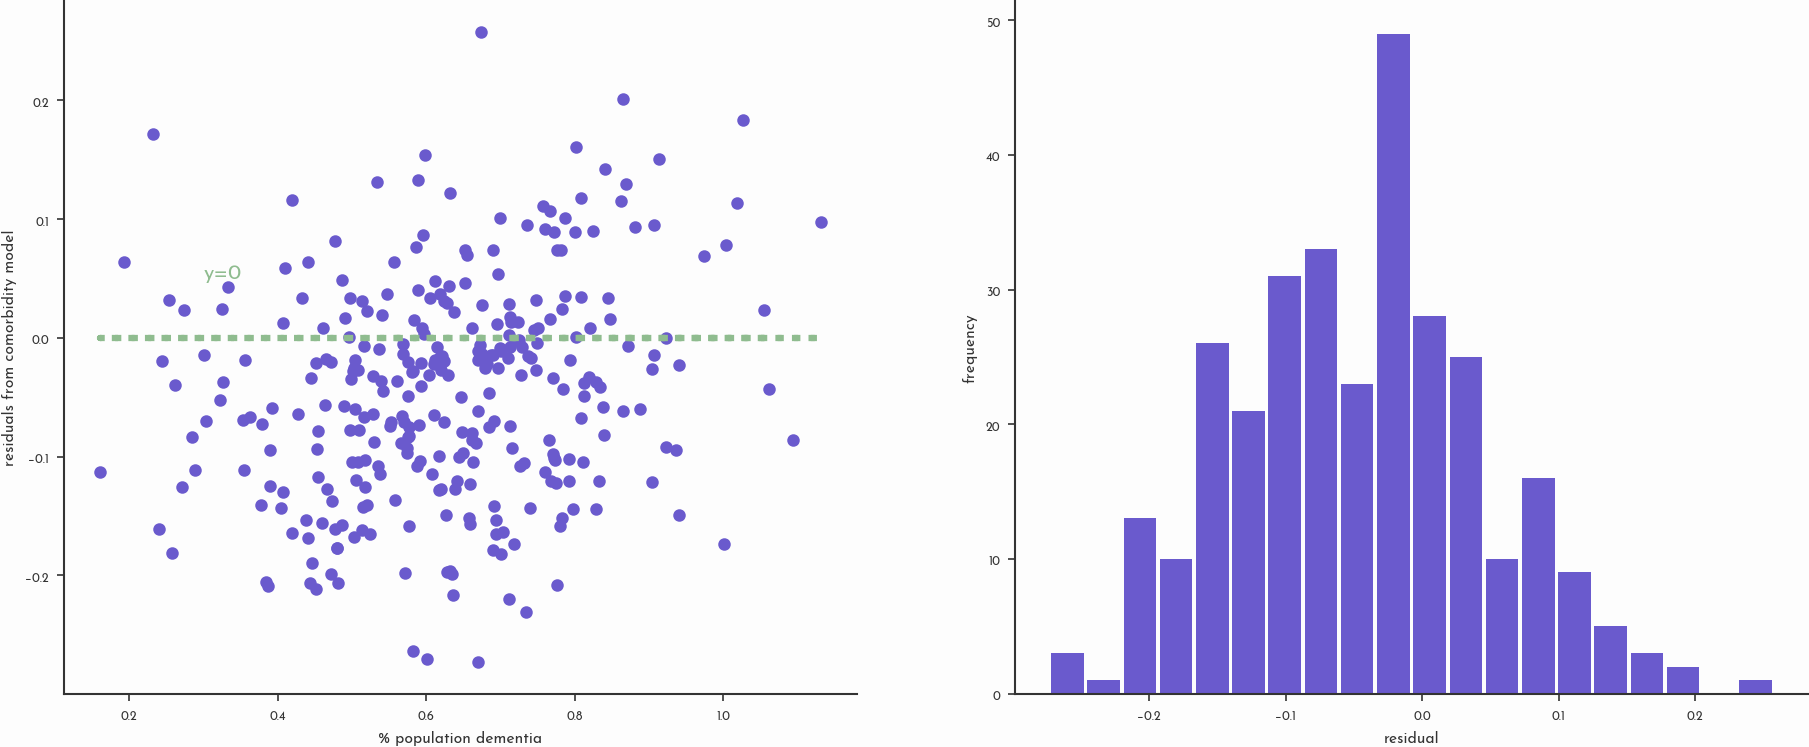

In [17]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals = (y_test_all-y_pred_all)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, residuals, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

### Save the results of the regression model to a .csv 

In [18]:
# add columns of results to the dataframe 
df_dem_plus['IMD_reg_model_residuals'] = residuals
df_dem_plus['IMD_reg_model_pred'] = y_pred_all

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/test_set_reg_model/IMD_reg_model_results.csv')

## Alternative using the GP density to select the training set 

In [19]:
# the 50 least deprived LADs according to GP density 
GP_vals = df_dem_plus['GP_LAD_pc'].values

df_highest_GP_50 = df_dem_plus.iloc[GP_vals.argsort()[-50:]]

# let's check this dataset 
df_highest_GP_50.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,IMD_reg_model_residuals,IMD_reg_model_pred
253,E07000066,Basildon,147650,836.308895,21230.763939,8435.195025,2707.627275,61857.0,96431.9056,91197.3989,...,32.967665,17.051058,51.394906,11.315271,4.495670,1.443073,312.348745,0.166471,-0.189748,0.635472
282,E06000034,Thurrock,134300,886.532257,19070.911233,7859.279298,2118.297546,57874.0,89792.8781,86056.9890,...,32.911029,13.621372,51.062238,10.844996,4.469312,1.204606,293.921392,0.167143,-0.019067,0.523209
225,E06000045,Southampton,205834,1664.001173,22723.123526,10561.641413,3355.664732,106655.0,123139.0873,123985.8311,...,43.158335,13.913978,49.828681,9.194995,4.273807,1.357882,415.383179,0.168086,0.257553,0.415791
153,E07000147,North Norfolk,90835,1034.032567,18155.040630,7024.203328,2744.019517,37817.0,52832.8744,50415.7460,...,36.627124,33.672700,51.170538,17.583809,6.803193,2.657682,174.669731,0.169174,-0.173635,1.175133
121,E09000003,Barnet,313694,2003.601221,35603.290480,16529.815112,4024.409402,190183.0,200300.8367,187905.7585,...,48.990152,14.562672,51.596454,9.171222,4.257994,1.036667,660.248227,0.170077,-0.006549,0.522666


In [20]:
# Linear regression using sklearn 

x_GP_train = df_highest_GP_50[covar_opt].values.reshape(-1,len(covar_opt))
y_GP_train = df_highest_GP_50['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_GP_train, y_GP_train)
y_pred_all_GP = regr.predict(x_test_all)

In [21]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:-0.43398036921361627
-------- 
 coefficients of independent variables 
 
over_65_pc:0.028601964367781434 

female_pc:0.012799124986834984 

ALevel_plus_pc:-0.0032728653428362687 

white_pc:3.12359190911393e-05 



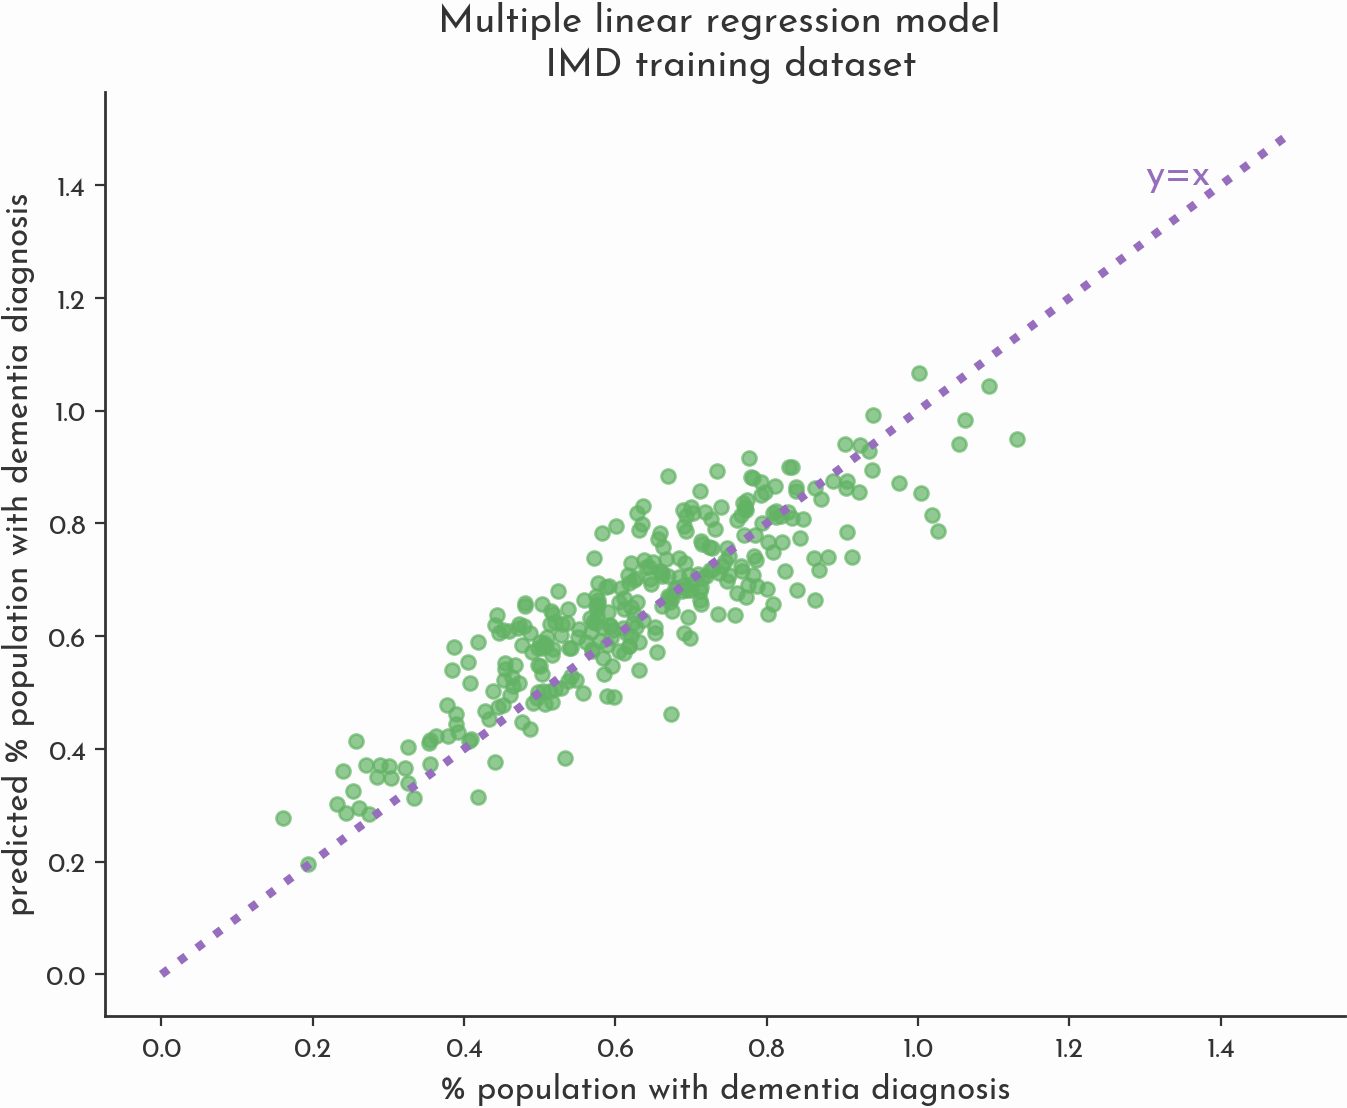

In [22]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='xkcd:deep lilac')
plt.scatter(y_test_all, y_pred_all_GP, color='xkcd:boring green', alpha=0.7)
plt.xlabel('% population with dementia diagnosis', fontsize=12)
plt.ylabel('predicted % population with dementia diagnosis', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Multiple linear regression model \n IMD training dataset', fontsize=14)
plt.text(1.3, 1.4, r'y=x', fontsize=14, color='xkcd:deep lilac')
plt.savefig(const.figs_path+'/IMD_linear_reg_scatter_plt.png')
plt.show()

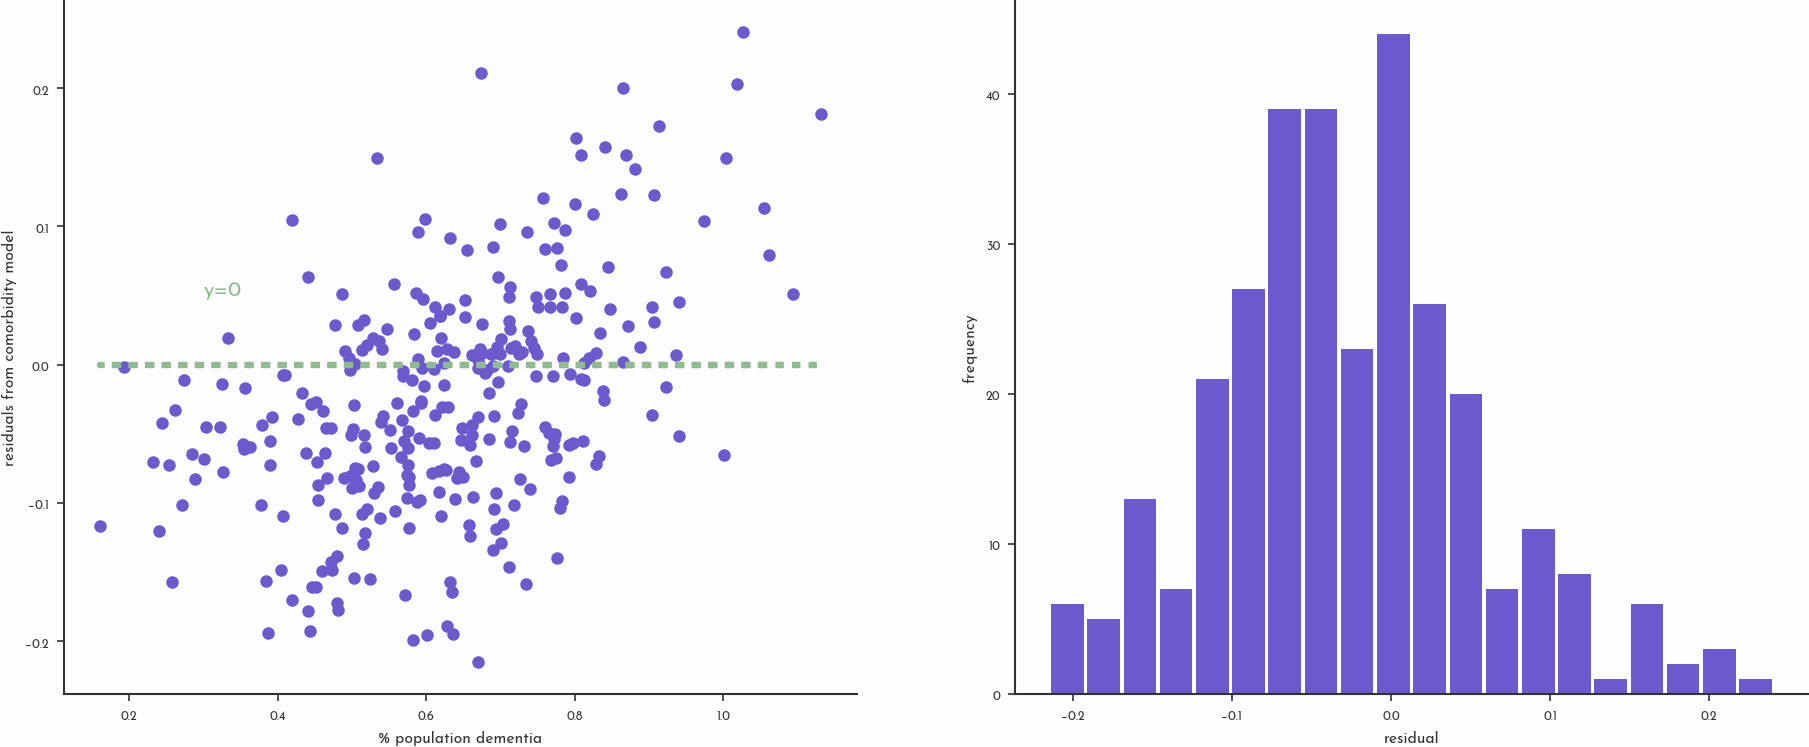

In [23]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

GP_residuals = (y_test_all-y_pred_all_GP)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, GP_residuals, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(GP_residuals, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

### Save the results of the (GP) regression model to a .csv 

In [24]:
# add columns of results to the dataframe 
df_dem_plus['GP_reg_model_residuals'] = GP_residuals
df_dem_plus['GP_reg_model_pred'] = y_pred_all_GP

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/test_set_reg_model/GP_reg_model_results.csv')